In [6]:
# import torch functions
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torch.nn.functional as F

# import torchvision functions
import torchvision
from torchvision.models import vgg16
import torchvision.utils as vutils
from torchvision import datasets, transforms, utils
import torchvision.transforms as T

# import other functions
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
from itertools import islice
from PIL import Image
import time 


In [7]:
original_dataset_dir = 'C:/Users/pauli/Documents/M2/ML et DL/projet/Git/DamageDetection'

In [8]:
train_damage_dir = original_dataset_dir + '/train_another/damage'
validation_damage_dir = original_dataset_dir + '/validation_another/damage'
test_damage_dir = original_dataset_dir + '/test/damage'

train_nodamage_dir = original_dataset_dir + '/train_another/no_damage'
validation_nodamage_dir = original_dataset_dir + '/validation_another/no_damage'
test_nodamage_dir = original_dataset_dir + '/test/no_damage'

In [9]:
print('total training damage images: ',len(os.listdir(train_damage_dir)))
print('total validation damage images: ',len(os.listdir(validation_damage_dir)))
print('total test damage images: ',len(os.listdir(test_damage_dir)))

print('total training no damage images: ',len(os.listdir(train_nodamage_dir)))
print('total validation no damage images: ',len(os.listdir(validation_nodamage_dir)))
print('total test no damage images: ',len(os.listdir(test_nodamage_dir)))

total training damage images:  5000
total validation damage images:  1000
total test damage images:  1000
total training no damage images:  5000
total validation no damage images:  1000
total test no damage images:  1000


In [10]:
# fonction pour entrainer les modeles

def fit(model, train_loader, val_loader, epochs, steps_per_epoch, validation_steps):
    epoch_nums = []
    training_acc = []
    validation_acc = []
    training_loss = []
    validation_loss = []
    start_time = time.time()
    
    for epoch in range(epochs):
        accuracy = 0.0
        running_loss = 0.0
        # Entraîne le modèle sur les données d'entraînement
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            # Entraîne le modèle sur un lot de données
            outputs = model(images)
            loss = criterion(outputs, labels.float().view(-1,1))
            loss_values.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #running_loss += loss.item()
            accuracy += (torch.round(outputs) == labels.float().view(-1,1)).sum().item() / len(labels)
            running_loss += loss.item()
        
            if (i+1) % steps_per_epoch == 0:
                break
        train_loss = running_loss / steps_per_epoch
        train_acc = accuracy / steps_per_epoch 
                
        
        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_acc = 0
            for i, (images, labels) in enumerate(val_loader):
                outputs = model(images)
                val_loss += criterion(outputs, labels.float().view(-1,1)).item()
                _, predicted = torch.max(outputs.data, 1)
                val_acc += (torch.round(outputs) == labels.float().view(-1,1)).sum().item() / len(labels)
                
                if i >= validation_steps:
                    break
        
        val_loss /= validation_steps
        val_acc /= validation_steps 

        epoch_nums.append(epoch+1)
        training_loss.append(train_loss)
        validation_loss.append(val_loss)
        training_acc.append(train_acc)
        validation_acc.append(val_acc)
        
        elapsed_time += time.time() - start_time
        print(elapsed_time)
        print(f"Epoch [{epoch+1}/{epochs}], Time : {elapsed_time}, Train Loss: {loss.item():.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
        
    return {
        'training_acc': training_acc,
        'validation_acc': validation_acc,
        'training_loss': training_loss,
        'validation_loss': validation_loss
    }

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, (3,3))
        self.pool1 = nn.MaxPool2d((2,2))
        self.conv2 = nn.Conv2d(32, 64, (3,3))
        self.pool2 = nn.MaxPool2d((2,2))
        self.conv3 = nn.Conv2d(64, 128, (3,3))
        self.pool3 = nn.MaxPool2d((2,2))
        self.conv4 = nn.Conv2d(128, 128, (3,3))
        self.pool4 = nn.MaxPool2d((2,2))
        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        x = F.relu(self.conv4(x))
        x = self.pool3(x)
        x = x.view(-1, 128 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
    
    

In [12]:
model = CNN()

In [162]:
import torchsummary
model = CNN()
torchsummary.summary(model, (3,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 148, 148]             896
         MaxPool2d-2           [-1, 32, 74, 74]               0
            Conv2d-3           [-1, 64, 72, 72]          18,496
         MaxPool2d-4           [-1, 64, 36, 36]               0
            Conv2d-5          [-1, 128, 34, 34]          73,856
         MaxPool2d-6          [-1, 128, 17, 17]               0
            Conv2d-7          [-1, 128, 15, 15]         147,584
         MaxPool2d-8            [-1, 128, 7, 7]               0
            Linear-9                  [-1, 512]       3,211,776
           Linear-10                    [-1, 1]             513
Total params: 3,453,121
Trainable params: 3,453,121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 11.53
Params size (MB): 13.17
Estim

In [163]:
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.0001)

In [164]:
train_datagen = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    #transforms.Normalize((0,), (1/255,))
])

train_dataset = ImageFolder('C:/Users/pauli/Documents/M2/ML et DL/projet/Git/DamageDetection/train_another', transform=train_datagen)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)

validation_datagen = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    #transforms.Normalize((0,), (1/255,))
])

val_dataset = ImageFolder('C:/Users/pauli/Documents/M2/ML et DL/projet/Git/DamageDetection/validation_another', transform=validation_datagen)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=True)


In [165]:
print('Found {} images belonging to {} classes.'.format(len(train_dataset), len(train_dataset.classes)))
print('Found {} images belonging to {} classes.'.format(len(val_dataset), len(val_dataset.classes)))

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [166]:

# Initialisation des paramètres 
steps_per_epoch = 100
epochs = 5
validation_steps = 50

# Lancer l'entraînement
history = fit(model, train_loader, val_loader, epochs, steps_per_epoch, validation_steps)

Epoch [1/5], Train Loss: 0.4471, Train Accuracy: 0.6510, Validation Loss: 0.4628, Validation Accuracy: 0.8200
Epoch [2/5], Train Loss: 0.1364, Train Accuracy: 0.8110, Validation Loss: 0.3195, Validation Accuracy: 0.9000
Epoch [3/5], Train Loss: 0.3148, Train Accuracy: 0.8610, Validation Loss: 0.2640, Validation Accuracy: 0.9150
Epoch [4/5], Train Loss: 0.2547, Train Accuracy: 0.8910, Validation Loss: 0.2378, Validation Accuracy: 0.9210
Epoch [5/5], Train Loss: 0.0986, Train Accuracy: 0.9035, Validation Loss: 0.2180, Validation Accuracy: 0.9350


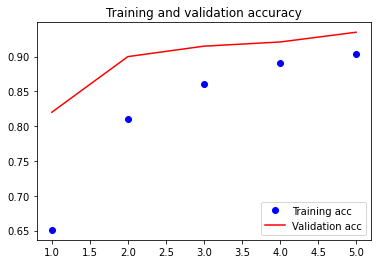

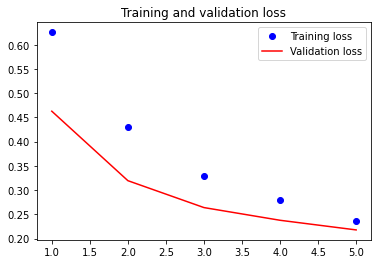

In [167]:
training_acc = history['training_acc']
validation_acc = history['validation_acc']
training_loss = history['training_loss']
validation_loss = history['validation_loss']
epoch_nums = range(1,len(training_acc)+1)

plt.plot(epoch_nums, training_acc, 'bo', label = 'Training acc')
plt.plot(epoch_nums, validation_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epoch_nums, training_loss, 'bo', label = 'Training loss')
plt.plot(epoch_nums, validation_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
img_path = 'C:/Users/pauli/Documents/M2/ML et DL/projet/Git/DamageDetection/damage/-96.960704_28.783292.jpeg'

img = Image.open(img_path)
img = img.resize((150,150))
img_tensor = np.array(img)
img_tensor = img_tensor.transpose((2, 0, 1))
img_tensor = img_tensor[np.newaxis, :]
img_tensor = img_tensor.astype('float32') / 255.

print(img_tensor.shape)

(1, 3, 150, 150)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


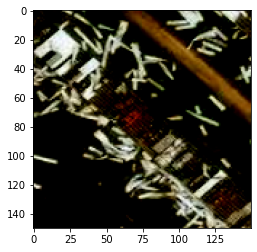

In [14]:
img_path = 'C:/Users/pauli/Documents/M2/ML et DL/projet/Git/DamageDetection/damage/-96.960704_28.783292.jpeg'

transform = T.Compose([
    T.Resize((150, 150)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

img = Image.open(img_path)
img_tensor = transform(img).unsqueeze(0)

# visualizing the tensor
plt.imshow(img_tensor[0].permute(1, 2, 0))
plt.show()


In [15]:
def get_activations(model, input_data):
    activations = []
    activations.append(input_data)
    for i, layer in enumerate(model):
        activations.append(layer(activations[i]))
    return activations

In [16]:
layer_outputs = []
layer_names = []
# Boucle sur les 8 premières couches du modèle
for i, module in enumerate(list(model.children())[:8]):
    layer_outputs.append(module)
    layer_names.append(f"Layer {i}")

# Appeler la fonction pour obtenir les activations des 8 premières couches
activations = get_activations(layer_outputs, img_tensor)

# Définir le nombre d'images par ligne
images_per_row = 16


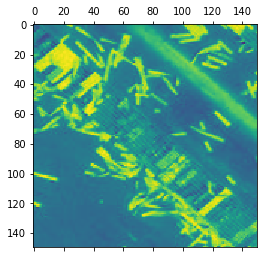

In [17]:
first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0][0, :, :], cmap='viridis')


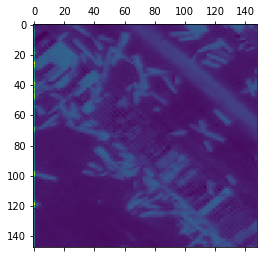

In [22]:
second_layer_activation = activations[1]
plt.matshow(second_layer_activation[0][0, :, :].detach().numpy(),cmap = 'viridis')


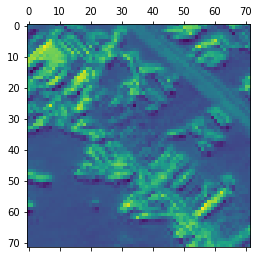

In [23]:
third_layer_activation = activations[3]
plt.matshow(third_layer_activation[0][0, :, :].detach().numpy(), cmap='viridis')


C:\Users\pauli\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


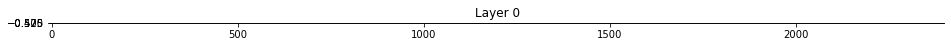

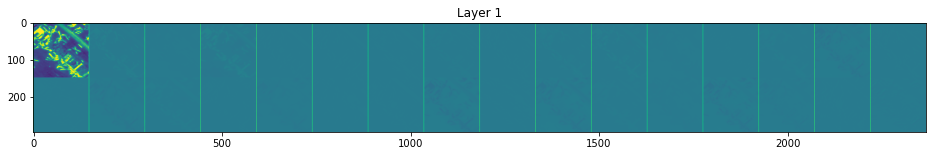

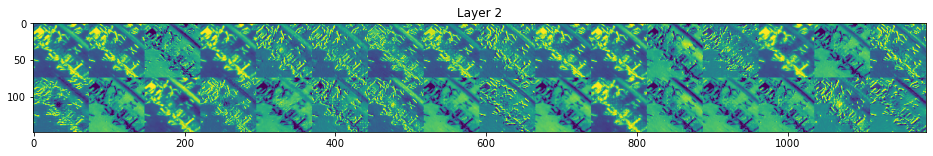

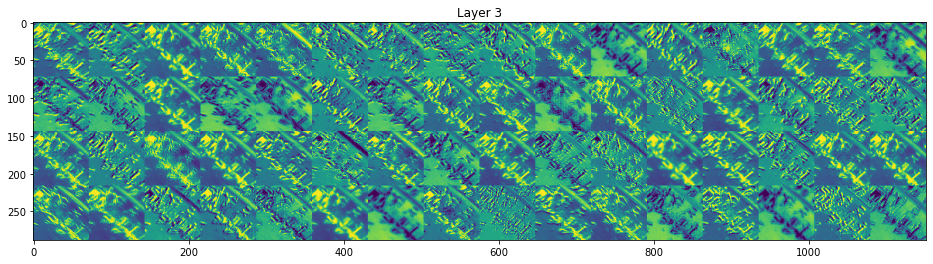

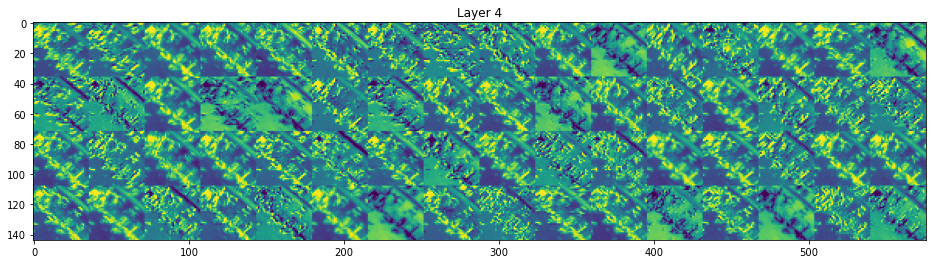

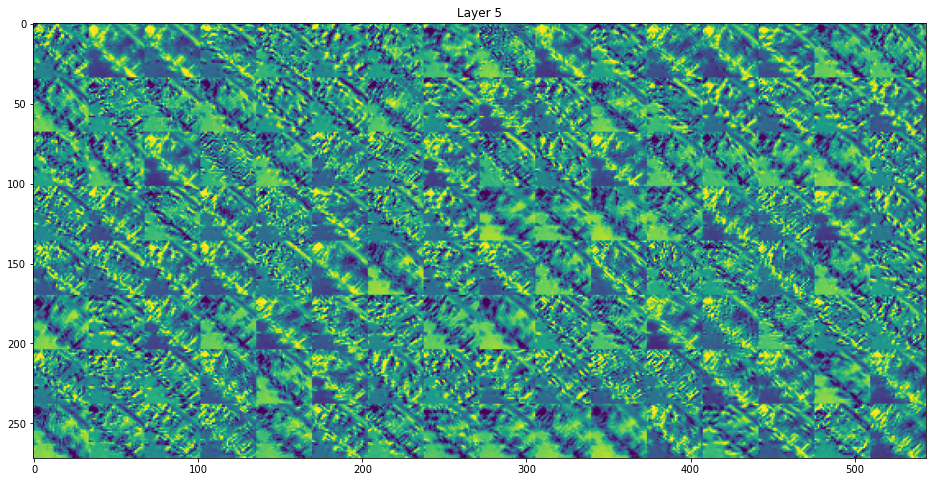

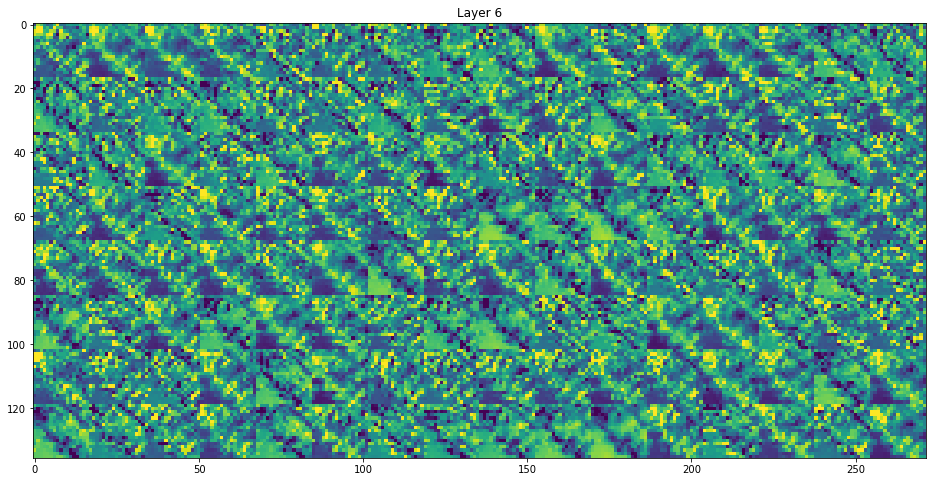

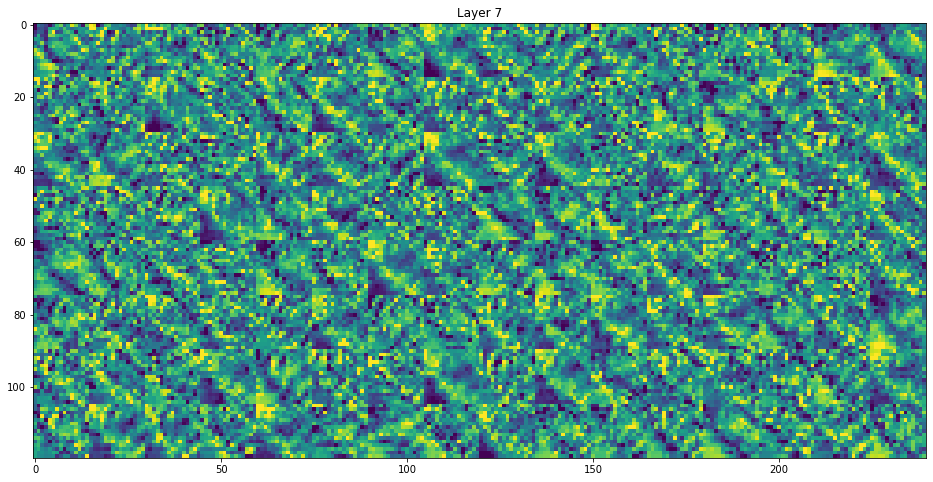

In [21]:
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[1]
    size = layer_activation.shape[2]
    n_cols = n_features//images_per_row
    display_grid = np.zeros((n_cols * size, images_per_row * size))
    layer_activation = layer_activation.detach().numpy()
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, col*images_per_row + row, :, :]
            #channel_image = layer_activation[0,:,:,col*images_per_row+row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, 
                         row * size : (row + 1) * size] = channel_image
    scale = 1./size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    